<a href="https://colab.research.google.com/github/MrR8bot/Emoji-DIctionary/blob/master/StockpredictionAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [1]:
import pandas as pd

##Data Preparation

In [2]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 81.1 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

##Data Pre-processing

##Make sure that the file of the stock is uploaded. Test stock use ticker.csv

In [7]:
def parser(x):
  return datetime.datetime.strptime(x,'%Y-%m-%d')

In [9]:
dataset_ex_df = pd.read_csv('ticker.csv', header=0, parse_dates=[0], date_parser=parser)

#Display the data

In [10]:
dataset_ex_df[['Date', 'Close']].head(3)

,Date,Close
0,2000-05-05,89.8750
1,2000-05-08,87.3125
2,2000-05-09,85.6250


In [11]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 5623 number of days in the dataset.


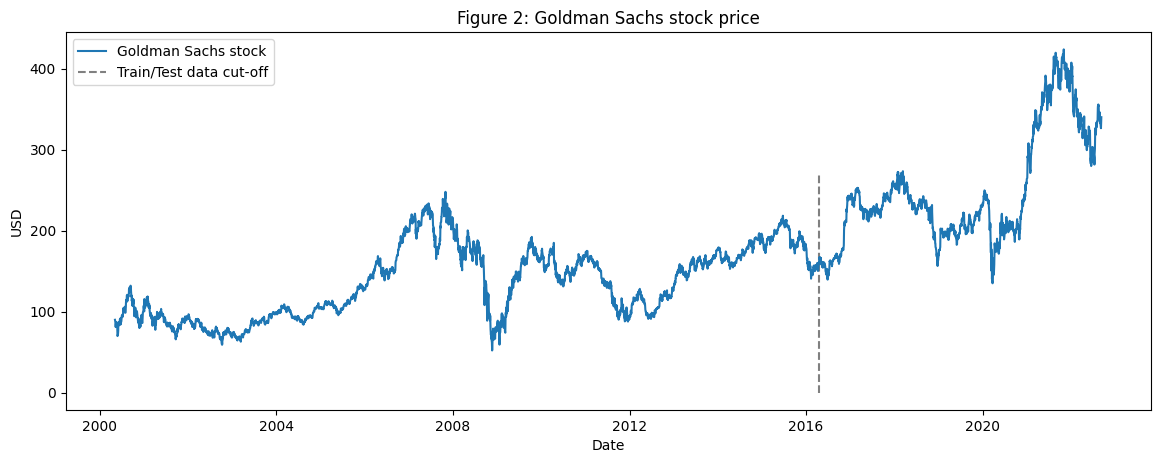

In [12]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [13]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 3936. Number of test days: 1687.


## Correlated Assets

First are the companies similar to GS. We will add JPMorgan Chase and Morgan Stanley, among others, to the dataset.
As an investment bank, Goldman Sachs depends on the global economy. Bad or volatile economy means no M&As or IPOs, and possibly limited proprietary trading earnings. That is why we will include global economy indices. Also, we will include LIBOR (USD and GBP denominated) rate, as possibly shocks in the economy might be accounted for by analysts to set these rates, and other FI securities.
Daily volatility index (VIX) - for the reason described in the previous point.
Composite indices - such as NASDAQ and NYSE (from USA), FTSE100 (UK), Nikkei225 (Japan), Hang Seng and BSE Sensex (APAC) indices.
Currencies - global trade is many times reflected into how currencies move, ergo we'll use a basket of currencies (such as USDJPY, GBPUSD, etc) as features.

Overall, we have 72 other assets in the dataset - daily price for every asset. TODO (Implementation needed)

##Technical indicators

In [14]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average

    dataset['ma7'] = dataset['Close'].rolling(7).mean()
    dataset['ma21'] = dataset['Close'].rolling(21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1

    # Create RSI Indicator

    #Get difference of prices from prev day
    delta = dataset['Close'].diff(1)

    #Remove NaN
    delta = delta.dropna()

    #Get ups and downs
    up = delta.copy()
    down = delta.copy()

    up[up<0] = 0
    down[down>0] = 0

    #Setting time period of 14 for RSI
    period = 14

    #Average gains and losees
    avg_gains = up.rolling(window=period).mean()
    avg_losses = abs(down.rolling(window=period).mean())

    #Calculate RS
    rs = avg_gains / avg_losses

    #Calculate RSI
    rsi = 100.0 - (100.0 / (1.0 + rs))

    dataset['RSI'] = rsi
    
    
    # removing all the NULL values using
    # dropna() method
    dataset.dropna(inplace=True)


    return dataset

In [15]:
#Calculate short term exponential moving average / ema
short_ema = dataset_ex_df['Close'].ewm(span=12, adjust=False).mean()

#Calculate short term exponential moving average / ema
long_ema = dataset_ex_df['Close'].ewm(span=26, adjust=False).mean()

#MACD line
macd = short_ema - long_ema

#Signal line
signal = macd.ewm(span=9, adjust=False).mean()

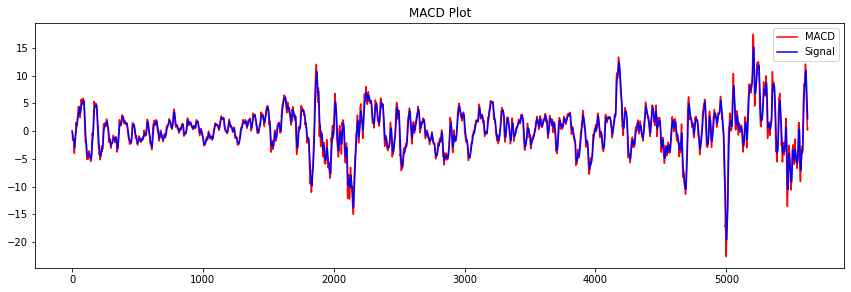

In [16]:
#Visualize MACD
plt.figure(figsize=(14.5, 4.5))
plt.title('MACD Plot')
plt.plot(dataset_ex_df.index, macd, label='MACD', color='red')
plt.plot(dataset_ex_df.index, signal, label='Signal', color='blue')
plt.legend()
plt.show()

In [17]:
## Calculate indicators

In [18]:
##Moving Averages

In [19]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['Close']])

In [21]:
##Visualize indicators for 400 days

In [22]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['RSI'],label='RSI', color='y')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')
  
    plt.legend()
    plt.show()

In [23]:
##Plot RSI

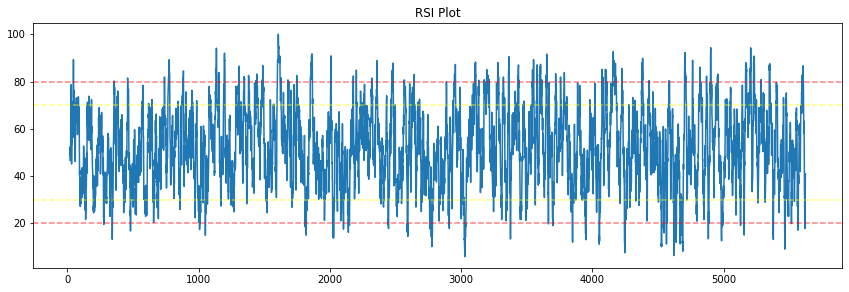

In [24]:
plt.figure(figsize=(14.5, 4.5))
plt.title('RSI Plot')
plt.plot(dataset_TI_df.index, dataset_TI_df['RSI'])
plt.axhline(20, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='yellow')
plt.axhline(70, linestyle='--', alpha=0.5, color='yellow')
plt.axhline(80, linestyle='--', alpha=0.5, color='red')
plt.show()

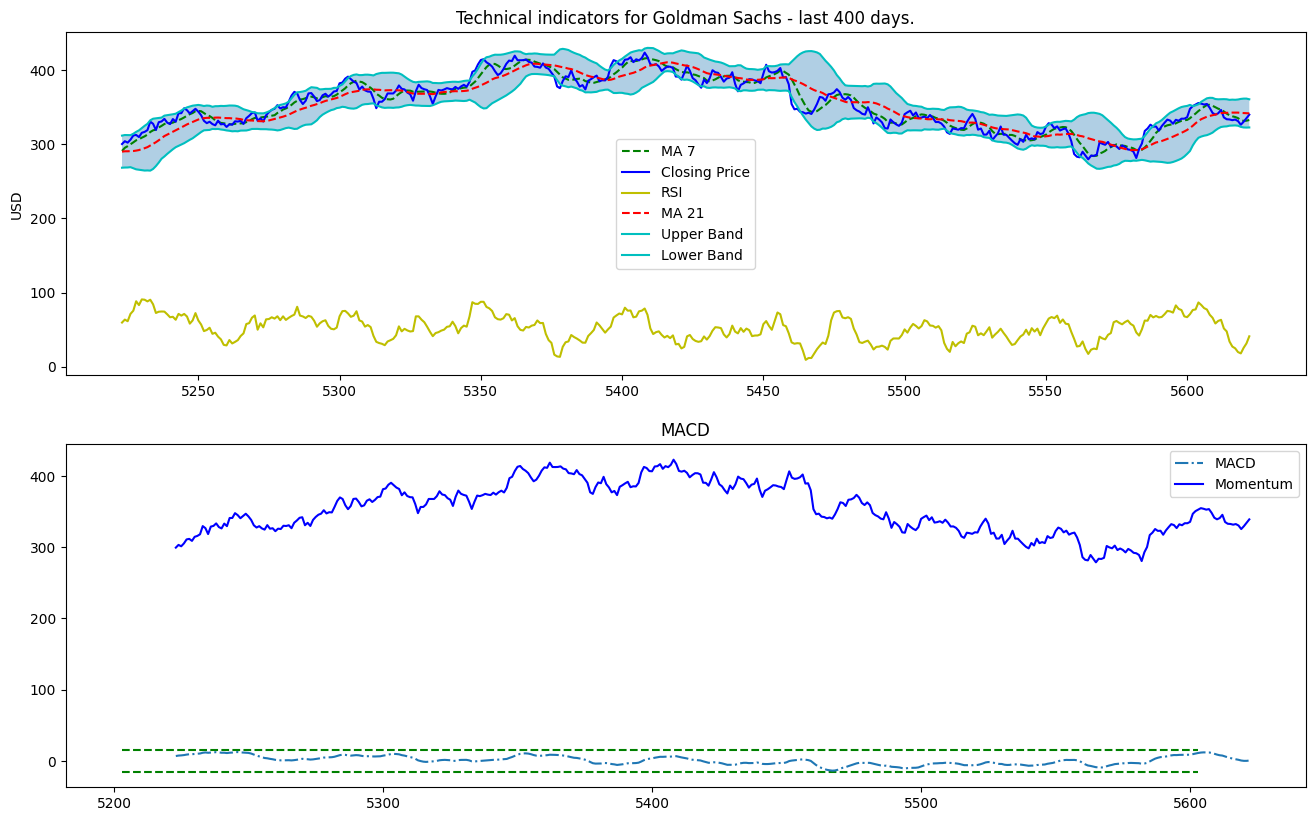

In [25]:
plot_technical_indicators(dataset_TI_df, 400)

### Fundamental Analysis

##Bidirectional Embedding Representations from Transformers - BERT (TO DO Pending Implementation of Sentiment Analysis)

In [ ]:
##Bidirectional Embedding Representations from Transformers - BERT

In [26]:
pip install bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bert: filename=bert-2.2.0-py3-none-any.whl size=3765 sha256=7dbff9bc0682f852dece76995beb69e41cd1795a78fb075b6f3988f7dbcbbfcb
  Stored in directory: /root/.cache/pip/wheels/bb/31/1b/c05f362e347429b7436954d1a2280fe464731e8f569123a848
  Created wheel for erlastic: filename=erlastic-2.0.0-py3-none-any.whl size=6794 sha256=c199c0b2d814a3cc6e3f46f79442c1b22fac3648f68d2f00cf60bd8b6de1f78d
  Stored in directory: /root/.cache/pip/wheels/94/f1/b4/0b98b1e94775da6a0b1130e342d22af05cd269e1172c19f40f
Successfully built bert erlastic


In [27]:
#just import bert
import bert

#Fourier transforms for trend analysis

In [28]:
data_FT = dataset_ex_df[['Date', 'Close']]

In [29]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

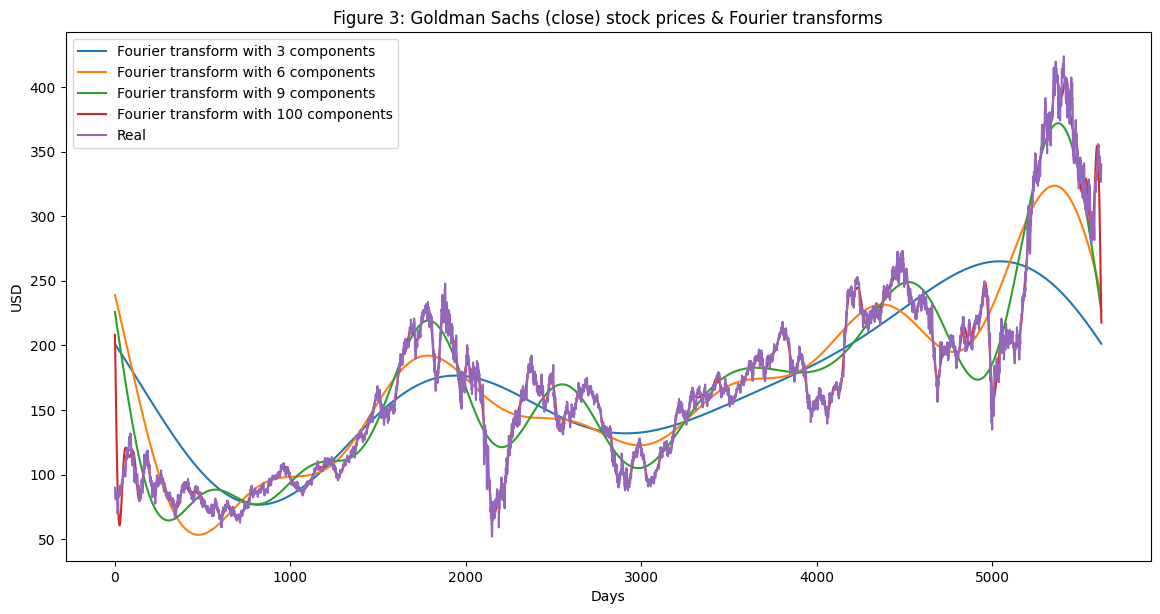

In [30]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

The more components from the Fourier transform we use the closer the approximation function is to the real stock price (the 100 components transform is almost identical to the original function - the red and the purple lines almost overlap). We use Fourier transforms for the purpose of extracting long- and short-term trends so we will use the transforms with 3, 6, and 9 components. You can infer that the transform with 3 components serves as the long term trend.

##Wavelets

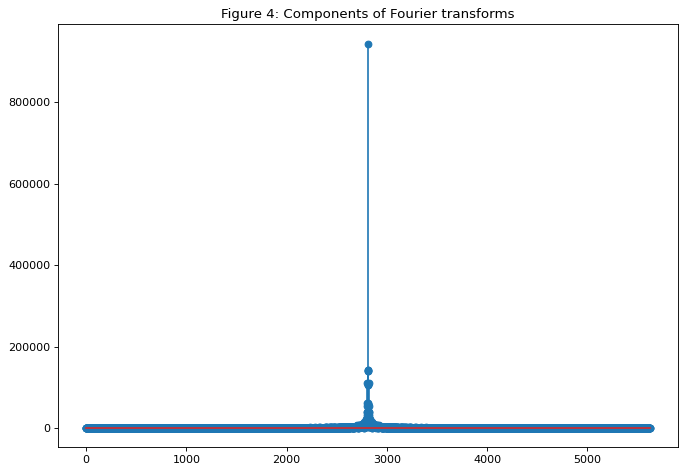

In [31]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## ARIMA as a feature

ARIMA is a technique for predicting time series data. We will show how to use it, and althouth ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.

In [32]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5622
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14976.145
Method:                       css-mle   S.D. of innovations              3.473
Date:                Thu, 15 Sep 2022   AIC                          29966.289
Time:                        04:58:16   BIC                          30012.730
Sample:                             1   HQIC                         29982.470
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0445      0.043      1.031      0.302      -0.040       0.129
ar.L1.D.Close    -0.0305      0.013     -2.286      0.022      -0.057      -0.004
ar.L2.D.Close     0.0132      0.013     

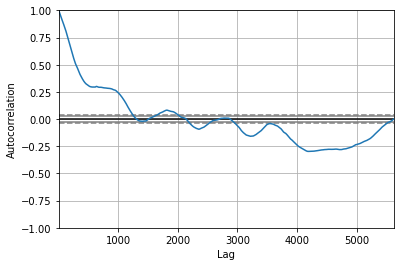

<Figure size 800x560 with 0 Axes>

In [33]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [ ]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

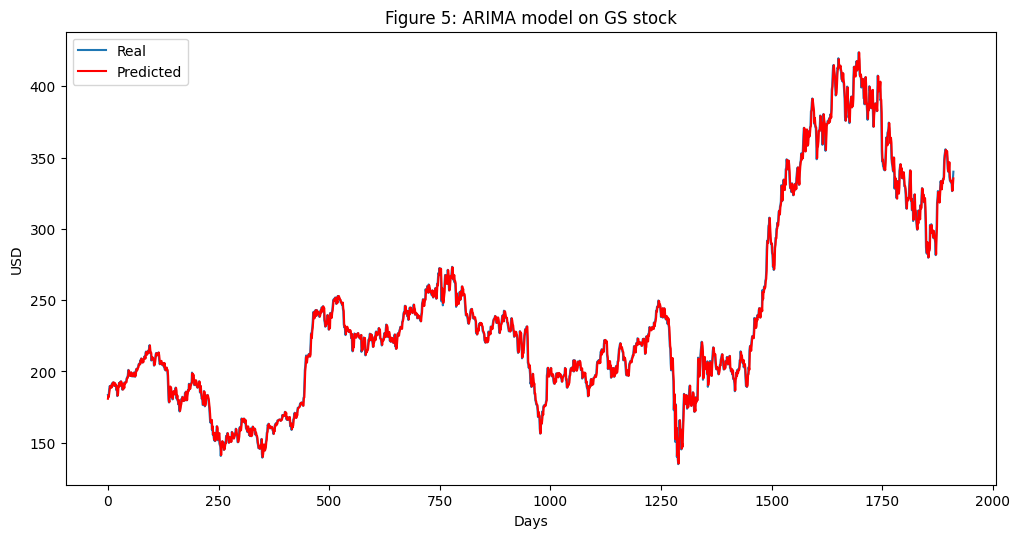

In [ ]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

#Statisticals checks

 Ensuring that the data has good quality is very important for out models. In order to make sure our data is suitable we will perform a couple of simple checks in order to ensure that the results we achieve and observe are indeed real, rather than compromised due to the fact that the underlying data distribution suffers from fundamental errors.

##Heteroskedasticity, multicollinearity, serial correlation
Conditional Heteroskedasticity occurs when the error terms (the difference between a predicted value by a regression and the real value) are dependent on the data - for example, the error terms grow when the data point (along the x-axis) grow.
Multicollinearity is when error terms (also called residuals) depend on each other.
Serial correlation is when one data (feature) is a formula (or completely depemnds) of another feature.
We will not go into the code here as it is straightforward and our focus is more on the deep learning parts, but the data is qualitative.

#Feature Engineering

In [ ]:
print('Total dataset has {} samples, and {} features.'.format(dataset_TI_df.shape[0], \
                                                              dataset_TI_df.shape[1]))

Total dataset has 5603 samples, and 12 features.


##Feature importance with XGBoost

Having so many features we have to consider whether all of them are really indicative of the direction GS stock will take. For example, we included USD denominated LIBOR rates in the dataset because we think that changes in LIBOR might indicate changes in the economy, that, in turn, might indicate changes in the GS's stock behavior. But we need to test. There are many ways to test feature importance, but the one we will apply uses XGBoost, because it gives one of the best results in both classification and regression problems.

       Since the features dataset is quite large, for the purpose of presentation here we'll use only the technical indicators. During the real features importance testing all selected features proved somewhat important so we won't exclude anything when training the GAN.

In [ ]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)



In [ ]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [ ]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[11:17:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
eval_result = regressor.evals_result()

In [ ]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

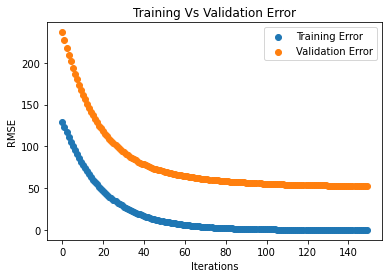

In [ ]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

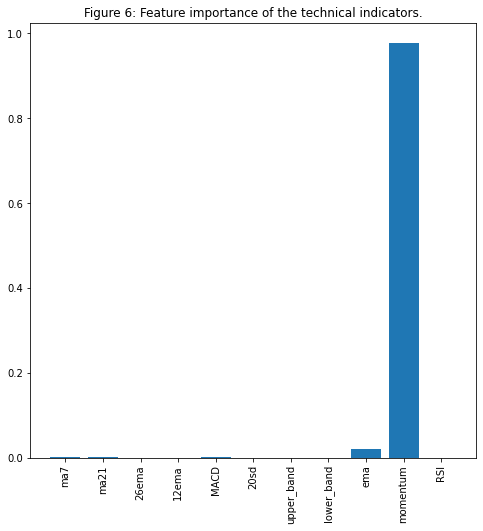

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

#Extracting high-level features with Stacked Autoencoders

Activation function - GELU (Gaussian Error)

In [ ]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

#Visualisation of GELU, RELU, LeakyReLU

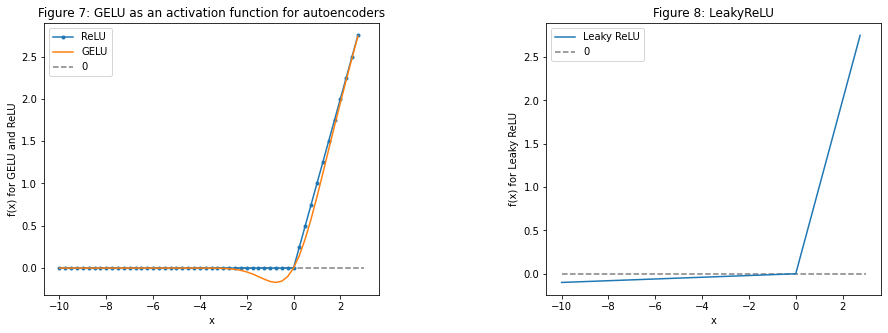

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

#Autoenconders

In [ ]:
VAE_data = dataset_TI_df

In [ ]:
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

In [ ]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [ ]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type='relu')

In [ ]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [ ]:
print(net)

VAE(
  (encoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 4, linear)
  )
  (decoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 11, Activation(sigmoid))
  )
)


So we have 3 layers (with 400 neurons in each) in both the encoder and the decoder

In [ ]:
import time

In [ ]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

Training completed in 440 seconds.


In [ ]:
dataset_TI_df['Date'] = dataset_ex_df['Date']

In [ ]:
vae_added_df = mx.nd.array(dataset_TI_df.iloc[:, :-1].values)

In [ ]:
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))

The shape of the newly created (from the autoencoder) features is (5603, 12).


In [ ]:
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))

The shape of the newly created (from the autoencoder) features is (5603, 12).


We created 112 more features from the autoencoder. As we want to only have high level features (overall patterns) we will create an Eigen portfolio on the newly created 112 features using Principal Component Analysis (PCA). This will reduce the dimension (number of columns) of the data. The descriptive capability of the Eigen portfolio will be the same as the original 112 features.

Note Once again, this is purely experimental. I am not 100% sure the described logic will hold. As everything else in AI and deep learning, this is art and needs experiments.

Eigen portafolio with PCA

# We want the PCA to create new components to explain 80% of the variance

Using the function

In [ ]:
pca = PCA(n_components=.8)

In [ ]:
#from sklearn.preprocessing import scale
#x_pca = scale(vae_added_df)

Having problems with the use of the pca funtion due to exceeding the maximum number of dimensions fo 32

In [ ]:
#x_pca = StandardScaler().fit_transform(vae_added_df)

NameError: ignored

In [ ]:
#principalComponents = pca.fit_transform(x_pca)

In [ ]:
#principalComponents.n_components_